# Getting started with astir

## 0. Load necessary libraries

In [55]:
# !pip install -e ../../..
from astir.data_readers import from_csv_yaml

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load data

We start by reading expression data in the form of a csv file and marker gene information in the form of a yaml file:

In [56]:
expression_mat_path = "../../../astir/tests/test-data/sce.csv"
yaml_marker_path = "../../../astir/tests/test-data/jackson-2020-markers.yml"

.. note:: 
    Expression data should already be cleaned and normalized. In our workflow, we perform this by a log-transformation of the data with a pseudocount of 1 (i.e. `log(x+1)`), followed by winsorization at the (1%,99%) percentiles.

We can view both the expression data and marker data:

In [57]:
!head -n 20 ../../../astir/tests/test-data/jackson-2020-markers.yml


cell_states:
  RTK_signalling:
    - Her2
    - EGFR
  proliferation:
    - Ki-67
    - phospho Histone
  mTOR_signalling:
    - phospho mTOR
    - phospho S6
  apoptosis:
    - cleaved PARP
    - Cleaved Caspase3

cell_types:
  Stromal:
    - Vimentin
    - Fibronectin
  B cells:


In [58]:
pd.read_csv(expression_mat_path, index_col=0)[['EGFR','E-Cadherin', 'CD45', 'Cytokeratin 5']].head()

,EGFR,E-Cadherin,CD45,Cytokeratin 5
BaselTMA_SP41_186_X5Y4_3679,0.346787,0.938354,0.227730,0.095283
BaselTMA_SP41_153_X7Y5_246,0.833752,1.364884,0.068526,0.124031
BaselTMA_SP41_20_X12Y5_197,0.110006,0.177361,0.301222,0.052750
BaselTMA_SP41_14_X1Y8_84,0.282666,1.122174,0.606941,0.093352
BaselTMA_SP41_166_X15Y4_266,0.209066,0.402554,0.588273,0.064545


Then we can create an astir object using the `from_csv_yaml` function. For more data loading options, see the data loading tutorial.

In [59]:
ast = from_csv_yaml(expression_mat_path, marker_yaml=yaml_marker_path)
print(ast)

Astir object with 6 cell types, 4 cell states, and 100 cells.


## 2. Fitting cell types

To fit cell types, simply call

In [60]:
ast.fit_type()

training astir: 100%|██████████| 49/49 [00:00<00:00, 54.21epochs/s]
/Users/sunyunlee/Desktop/astir/astir/astir.py:176: UserWarning: Maximum epochs reached. More iteration may be needed to complete the training.
  warnings.warn(msg)


---------- Astir Training 1/5 ----------
Done!
---------- Astir Training 2/5 ----------
Done!
---------- Astir Training 3/5 ----------
Done!
---------- Astir Training 4/5 ----------
Done!
---------- Astir Training 5/5 ----------
Done!
Done!


.. note:: 
    **Controlling inference**
    There are many different options for controlling inference in the `fit_type` function, including
    `max_epochs` (maximum number of epochs to train),
    `learning_rate` (ADAM optimizer learning rate),
    `batch_size` (minibatch size),
    `delta_loss` (stops iteration once the change in loss falls below this value),
    `n_inits` (number of restarts using random initializations).
    For full details, see the function documentation.

We should always plot the losses to assess convergence:

Text(0.5, 0, 'Epoch')

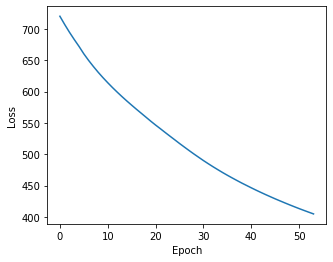

In [61]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_type_losses())), ast.get_type_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

We can then get cell type assignment probabilities by calling

In [62]:
assignments = ast.get_celltype_probabilities()
assignments

,Stromal,B cells,T cells,Macrophage,Epithelial (basal),Epithelial (luminal),Other
BaselTMA_SP41_186_X5Y4_3679,0.177793,0.144371,0.223440,0.309970,0.013035,0.030133,0.101258
BaselTMA_SP41_153_X7Y5_246,0.007816,0.027602,0.015783,0.012242,0.085803,0.835951,0.014804
BaselTMA_SP41_20_X12Y5_197,0.170099,0.140966,0.215053,0.344163,0.012578,0.015104,0.102035
BaselTMA_SP41_14_X1Y8_84,0.139059,0.130092,0.144493,0.129623,0.118295,0.237833,0.100605
BaselTMA_SP41_166_X15Y4_266,0.187228,0.168200,0.202668,0.332506,0.011055,0.018291,0.080051
...,...,...,...,...,...,...,...
BaselTMA_SP41_114_X13Y4_1057,0.043763,0.090134,0.119576,0.060088,0.288445,0.336696,0.061298
BaselTMA_SP41_141_X11Y2_2596,0.026656,0.074330,0.099706,0.069662,0.256433,0.420001,0.053212
BaselTMA_SP41_100_X15Y5_170,0.171607,0.160552,0.179363,0.246715,0.068977,0.076316,0.096470
BaselTMA_SP41_14_X1Y8_2604,0.161624,0.131741,0.232924,0.348536,0.007337,0.016461,0.101378


where each row corresponds to a cell, and each column to a cell type, with the entry being the probability of that cell belonging to a particular cell type.

To fetch an array corresponding to the most likely cell type assignments, call

In [63]:
ast.get_celltypes()

,cell_type
BaselTMA_SP41_186_X5Y4_3679,Unknown
BaselTMA_SP41_153_X7Y5_246,Epithelial (luminal)
BaselTMA_SP41_20_X12Y5_197,Unknown
BaselTMA_SP41_14_X1Y8_84,Unknown
BaselTMA_SP41_166_X15Y4_266,Unknown
...,...
BaselTMA_SP41_114_X13Y4_1057,Unknown
BaselTMA_SP41_141_X11Y2_2596,Unknown
BaselTMA_SP41_100_X15Y5_170,Unknown
BaselTMA_SP41_14_X1Y8_2604,Unknown


### Cell type diagnostics

It is important to run diagnostics to ensure that cell types express their markers at higher levels than other cell types. To do this, run the `diagnostics_celltype()` function, which will alert to any issues if a cell type doesn't express its marker signficantly higher than an alternative cell type (for which that protein isn't a marker):

In [64]:
ast.diagnostics_celltype().head(n=10)

,feature,should be expressed higher in,than,mean cell type 1,mean cell type 2,p-value,note
0,CD3,T cells,Epithelial (basal),0.503084,0.036015,inf,Only 1 cell in a type: comparison not possible
1,CD3,T cells,Epithelial (luminal),0.503084,0.043545,inf,Only 1 cell in a type: comparison not possible
2,CD45,T cells,Epithelial (basal),1.149263,0.060033,inf,Only 1 cell in a type: comparison not possible
3,CD45,T cells,Epithelial (luminal),1.149263,0.053647,inf,Only 1 cell in a type: comparison not possible
4,Cytokeratin 14,Epithelial (basal),T cells,1.379118,0.191823,inf,Only 1 cell in a type: comparison not possible
5,Cytokeratin 5,Epithelial (basal),T cells,1.217177,0.043490,inf,Only 1 cell in a type: comparison not possible
6,E-Cadherin,Epithelial (basal),T cells,1.367456,0.553804,inf,Only 1 cell in a type: comparison not possible
7,Her2,Epithelial (basal),T cells,0.896201,0.522054,inf,Only 1 cell in a type: comparison not possible
8,pan Cytokeratin,Epithelial (basal),T cells,1.983426,0.061811,inf,Only 1 cell in a type: comparison not possible
9,Cytokeratin 19,Epithelial (luminal),T cells,1.007910,0.194989,inf,Only 1 cell in a type: comparison not possible


.. note:: 
    In this tutorial, we end up with many "Only 1 cell in a type: comparison not possible" notes - this is simply because the small dataset size results in only a single cell assigned to many types, making statistical testing infeasible.

Calling `ast.diagnostics_celltype()` returns a `pd.DataFrame`, where each column corresponds to a particular protein and two cell types, with a warning if the protein is not expressed at higher levels in the cell type for which it is a marker than the cell type for which it is not.

The diagnostics:

1. Iterates through every cell type and every marker for that cell type

2. Given a cell type *c* and marker *g*, find the set of cell types *D* that don't have *g* as a marker

3. For each cell type *d* in *D*, perform a t-test between the expression of marker *g* in *c* vs *d*

4. If *g* is not expressed significantly higher (at significance *alpha*), output a diagnostic explaining this for further investigation.

If multiple issues are found, the markers and cell types may need refined.

## 3. Fitting cell state

Similarly as before, to fit cell state, call

In [65]:
ast.fit_state(batch_size = 1024, learning_rate=1e-3, max_epochs=500)

/Users/sunyunlee/Desktop/astir/astir/models/cellstate.py:178: UserWarning: Delta loss batch size is greater than the number of epochs
  warnings.warn("Delta loss batch size is greater than the number of epochs")
training astir:   5%|▌         | 25/495 [00:00<00:01, 236.81epochs/s]


---------- Astir Training 1/5 ----------
---------- Astir Training 2/5 ----------
---------- Astir Training 3/5 ----------
---------- Astir Training 4/5 ----------
---------- Astir Training 5/5 ----------
Reached convergence -- breaking from training loop


and similary plot the losses via

Text(0.5, 0, 'Epoch')

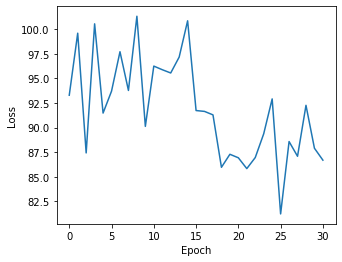

In [66]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_state_losses())), ast.get_state_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

and cell state assignments can be inferred via

In [67]:
states = ast.get_cellstates()
states

,RTK_signalling,proliferation,mTOR_signalling,apoptosis
BaselTMA_SP41_186_X5Y4_3679,-0.368113,0.514141,0.098024,-0.103672
BaselTMA_SP41_153_X7Y5_246,-0.351472,0.073310,0.059058,0.242761
BaselTMA_SP41_20_X12Y5_197,-0.182627,0.339505,0.282707,-0.003016
BaselTMA_SP41_14_X1Y8_84,-0.235495,0.409069,0.258528,-0.043412
BaselTMA_SP41_166_X15Y4_266,-0.188587,0.343978,0.281649,-0.011169
...,...,...,...,...
BaselTMA_SP41_114_X13Y4_1057,-0.171371,0.286135,0.256788,0.200971
BaselTMA_SP41_141_X11Y2_2596,-0.265984,0.379806,0.205499,-0.006201
BaselTMA_SP41_100_X15Y5_170,-0.183103,0.339862,0.282623,-0.003668
BaselTMA_SP41_14_X1Y8_2604,-0.235202,0.383918,0.236332,-0.029804


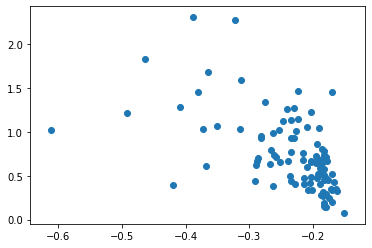

In [68]:
plt.scatter(
    states['RTK_signalling'],
    ast.get_state_dataset().get_exprs_df()['Her2']
)

### Cell state diagnostics

It is important to run diagnostics on cell states model for the same reasons
stated for the cell type model. `Astir.diagnostics_cellstate()` spots any non
 marker protein and pathway pairs whose expressions are higher than those of
 the marker proteins of the pathway.

In [69]:
ast.diagnostics_cellstate().head(n=10)

,pathway,protein A,correlation of protein A,protein B,correlation of protein B,note
0,RTK_signalling,Her2,-0.557551,Cleaved Caspase3,-0.477719,Her2 is marker for RTK_signalling but Cleaved ...
1,RTK_signalling,Her2,-0.557551,Ki-67,-0.069831,Her2 is marker for RTK_signalling but Ki-67 isn't
2,RTK_signalling,Her2,-0.557551,cleaved PARP,-0.477719,Her2 is marker for RTK_signalling but cleaved ...
3,RTK_signalling,Her2,-0.557551,phospho S6,-0.507912,Her2 is marker for RTK_signalling but phospho ...
4,proliferation,Ki-67,0.210566,Her2,0.319918,Ki-67 is marker for proliferation but Her2 isn't
5,proliferation,Ki-67,0.210566,phospho S6,0.508832,Ki-67 is marker for proliferation but phospho ...
6,proliferation,Ki-67,0.210566,phospho mTOR,0.331018,Ki-67 is marker for proliferation but phospho ...
7,mTOR_signalling,phospho mTOR,-0.765907,Cleaved Caspase3,-0.531901,phospho mTOR is marker for mTOR_signalling but...
8,mTOR_signalling,phospho mTOR,-0.765907,EGFR,-0.386706,phospho mTOR is marker for mTOR_signalling but...
9,mTOR_signalling,phospho mTOR,-0.765907,Her2,-0.413496,phospho mTOR is marker for mTOR_signalling but...


Calling `ast.diagnostics_cellstate()` returns a `pd.DataFrame`, where each
column corresponds to a particular protein and two cell types, with a warning
 if the protein is not expressed at higher levels in the cell state for which
 it is a marker than the cell state for which it is not.

The diagnostics:

1. Get correlations between all cell states and proteins

2. For each cell state *c*, get the smallest correlation with marker *g*

3. For each cell state *c* and its non marker *g*, find any correlation that is
bigger than those smallest correlation for *c*.

4. Any *c* and *g* pairs found in step 3 will be included in the output of
`Astir.diagnostics_cellstate()`, including an explanation.

If multiple issues are found, the markers and cell states may need refined.


## 4. Saving results

Both cell type and cell state information can easily be saved to disk via

In [70]:
ast.type_to_csv("cell-types.csv")
ast.state_to_csv("cell-states.csv")

In [71]:
!head -n 3 cell-types.csv

,Stromal,B cells,T cells,Macrophage,Epithelial (basal),Epithelial (luminal),Other
BaselTMA_SP41_186_X5Y4_3679,0.1777929323882057,0.14437103771092488,0.22343985090306523,0.30996987410607124,0.013035094864899337,0.030133346640283207,0.1012578633865505
BaselTMA_SP41_153_X7Y5_246,0.007816026326388233,0.02760153789549652,0.015782622566189734,0.012241668395157921,0.08580272158663274,0.8359512321761182,0.014804191054016572


In [72]:
!head -n 3 cell-states.csv

,RTK_signalling,proliferation,mTOR_signalling,apoptosis
BaselTMA_SP41_186_X5Y4_3679,-0.3681131942216142,0.5141407593180919,0.09802381766880391,-0.10367242118861601
BaselTMA_SP41_153_X7Y5_246,-0.3514723984822022,0.07330987372974418,0.05905841914750254,0.24276076283503867


where the first (unnamed) column always corresponds to the cell name/ID.

## 5. Accessing internal functions and data

Data stored in `astir` objects is in the form of an `SCDataSet`. These can be retrieved via

In [73]:
celltype_data = ast.get_type_dataset()
celltype_data

and similarly for cell state via `ast.get_state_dataset()`.

These have several helper functions to retrieve relevant information to the dataset:

In [74]:
celltype_data.get_cell_names()[0:4] # cell names

['BaselTMA_SP41_186_X5Y4_3679',
 'BaselTMA_SP41_153_X7Y5_246',
 'BaselTMA_SP41_20_X12Y5_197',
 'BaselTMA_SP41_14_X1Y8_84']

In [75]:
celltype_data.get_classes() # cell type names

['Stromal',
 'B cells',
 'T cells',
 'Macrophage',
 'Epithelial (basal)',
 'Epithelial (luminal)']

In [76]:
print(celltype_data.get_n_classes()) # number of cell types
print(celltype_data.get_n_features()) # number of features / proteins

6
14


In [77]:
celltype_data.get_exprs() # Return a torch tensor corresponding to the expression data used

tensor([[0.1026, 0.1004, 0.2277,  ..., 0.6097, 2.2151, 0.7714],
        [0.1081, 0.0176, 0.0685,  ..., 1.0622, 0.5026, 3.9632],
        [0.0498, 0.0943, 0.3012,  ..., 0.1601, 0.8102, 0.0481],
        ...,
        [0.0695, 0.0119, 0.0869,  ..., 0.4487, 0.7593, 1.4923],
        [0.0929, 0.1266, 0.2395,  ..., 0.4405, 2.2464, 0.4174],
        [0.0618, 0.1439, 0.2476,  ..., 0.7055, 3.1238, 0.2552]],
       dtype=torch.float64)

In [78]:
celltype_data.get_exprs_df() # Return a pandas DataFrame corresponding to the expression data used

,CD20,CD3,CD45,CD68,Cytokeratin 14,Cytokeratin 19,Cytokeratin 5,Cytokeratin 7,Cytokeratin 8/18,E-Cadherin,Fibronectin,Her2,Vimentin,pan Cytokeratin
BaselTMA_SP41_186_X5Y4_3679,0.102576,0.100401,0.227730,2.227252,0.195163,0.190923,0.095283,0.057050,0.461040,0.938354,1.829905,0.609694,2.215089,0.771352
BaselTMA_SP41_153_X7Y5_246,0.108137,0.017637,0.068526,0.208297,0.234853,0.685858,0.124031,0.485330,0.382767,1.364884,1.226994,1.062229,0.502627,3.963248
BaselTMA_SP41_20_X12Y5_197,0.049809,0.094316,0.301222,0.581624,0.072666,0.115979,0.052750,0.035875,0.020290,0.177361,2.222520,0.160135,0.810243,0.048100
BaselTMA_SP41_14_X1Y8_84,0.024256,0.140441,0.606941,0.490982,0.165863,0.652143,0.093352,0.351700,0.904383,1.122174,1.402750,1.133448,1.742495,1.917118
BaselTMA_SP41_166_X15Y4_266,0.138571,0.111722,0.588273,1.039967,0.162696,0.086235,0.064545,0.009627,0.046967,0.402554,2.669947,0.558439,1.659587,0.687005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BaselTMA_SP41_114_X13Y4_1057,0.185995,0.049244,0.151869,0.296231,0.151970,0.175114,0.108374,0.021539,0.207346,2.120132,0.743909,1.460545,0.069651,1.666665
BaselTMA_SP41_141_X11Y2_2596,0.100324,0.024006,0.025612,0.091424,0.049996,0.324138,0.083866,0.069627,0.614213,1.637392,0.860960,0.789372,0.000000,2.584532
BaselTMA_SP41_100_X15Y5_170,0.069503,0.011859,0.086852,0.538247,0.037131,0.321179,0.096496,0.000000,0.696445,0.861641,1.724828,0.448688,0.759268,1.492342
BaselTMA_SP41_14_X1Y8_2604,0.092944,0.126645,0.239459,1.967150,0.171216,0.132563,0.055748,0.082334,0.128377,0.532135,1.899111,0.440527,2.246434,0.417445


In [79]:
ast.normalize()

In [80]:
ast.get_type_dataset().get_exprs_df()

,CD20,CD3,CD45,CD68,Cytokeratin 14,Cytokeratin 19,Cytokeratin 5,Cytokeratin 7,Cytokeratin 8/18,E-Cadherin,Fibronectin,Her2,Vimentin,pan Cytokeratin
BaselTMA_SP41_186_X5Y4_3679,0.097649,0.095675,0.205167,1.088442,0.178283,0.174729,0.091013,0.055482,0.379148,0.661839,1.040243,0.476044,1.167855,0.571743
BaselTMA_SP41_153_X7Y5_246,0.102680,0.017483,0.066280,0.189212,0.210952,0.522274,0.116921,0.395637,0.324087,0.860729,0.800653,0.723787,0.407215,1.602060
BaselTMA_SP41_20_X12Y5_197,0.048608,0.090130,0.263304,0.458452,0.070148,0.109732,0.051405,0.035246,0.020086,0.163276,1.170164,0.148536,0.593461,0.046979
BaselTMA_SP41_14_X1Y8_84,0.023967,0.131415,0.474333,0.399435,0.153462,0.502073,0.089248,0.301363,0.644158,0.752441,0.876614,0.757740,1.008868,1.070596
BaselTMA_SP41_166_X15Y4_266,0.129774,0.105910,0.462647,0.712933,0.150741,0.082718,0.062548,0.009581,0.045898,0.338295,1.300177,0.443684,0.978171,0.522955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BaselTMA_SP41_114_X13Y4_1057,0.170582,0.048070,0.141386,0.259461,0.141473,0.161365,0.102894,0.021311,0.188425,1.137875,0.556129,0.900383,0.067333,0.980828
BaselTMA_SP41_141_X11Y2_2596,0.095605,0.023722,0.025290,0.087484,0.048787,0.280761,0.080535,0.067310,0.478848,0.969791,0.621092,0.581865,0.000000,1.276628
BaselTMA_SP41_100_X15Y5_170,0.067194,0.011789,0.083286,0.430644,0.036458,0.278524,0.092120,0.000000,0.528535,0.621458,1.002405,0.370658,0.564898,0.913223
BaselTMA_SP41_14_X1Y8_2604,0.088875,0.119244,0.214675,1.087602,0.158042,0.124483,0.054250,0.079120,0.120780,0.426662,1.064404,0.365009,1.177557,0.348856
